# Morfologia Matemática

**Professor:** Agora que temos imagens binárias (Preto e Branco), podemos brincar de massinha!

Morfologia matemática é sobre **forma** e **estrutura**. É como usar ferramentas para lapidar, lixar ou colar partes da imagem.
As operações básicas são simples, mas a combinação delas resolve problemas complexos como:
- Limpar ruído ("sujeira" na imagem).
- Fechar buracos em objetos.
- Encontrar esqueletos (linhas centrais) de estruturas.
- Separar objetos grudados.


> Tudo depende de uma "sonda" chamada **Elemento Estruturante (Structuring Element - SE)**.



## 0) Setup e Utilitários
Vamos configurar nossas ferramentas. Note a função `ensure_binary`: a morfologia depende criticamente de termos zeros e uns (ou 0 e 255) bem definidos.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Tenta importar skimage para o bônus final
try:
    from skimage.morphology import skeletonize
    HAS_SKIMAGE = True
except ImportError:
    HAS_SKIMAGE = False

plt.rcParams['figure.figsize'] = (12, 6)

def read_gray(path):
    """Lê imagem direto em tons de cinza."""
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Erro ao ler {path}")
    return img

def ensure_binary(img, thresh=127):
    """Garante que a imagem seja puramente binária (0 ou 255)."""
    _, binary = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY)
    return binary

def show_side_by_side(imgs, titles, cmap='gray', size=(15, 5)):
    """Plota imagens lado a lado para comparação fácil."""
    if len(imgs) != len(titles):
        raise ValueError("Imagens e Títulos devem ter o mesmo tamanho")
    
    fig, axes = plt.subplots(1, len(imgs), figsize=size)
    if len(imgs) == 1: axes = [axes]
    
    for ax, img, title in zip(axes, imgs, titles):
        ax.imshow(img, cmap=cmap)
        ax.set_title(title)
        ax.axis('off')
    plt.show()

## 1) Carregando e Preparando os Exemplos
Carregamos 3 imagens clássicas que representam problemas diferentes:
- **circles.png**: Objetos redondos, conexidade.
- **circuit.png**: Linhas finas, trilhas, ruído.
- **squares.png**: Formas geométricas, quinas, buracos.

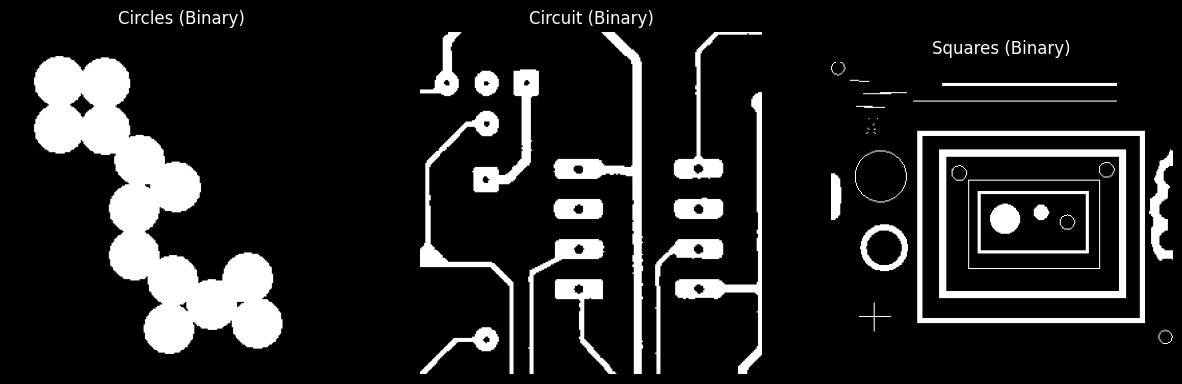

In [2]:
# Carregar imagens (substitua os caminhos se necessário)
circles = ensure_binary(read_gray('images/circles.png'))
circuit = ensure_binary(read_gray('images/circuit.png'))
squares = ensure_binary(read_gray('images/squares.png'))

# Check rápido (Visual + Histograma simples)
show_side_by_side([circles, circuit, squares], 
                  ["Circles (Binary)", "Circuit (Binary)", "Squares (Binary)"])

## 2) O Elemento Estruturante (SE)

**Professor:** A Intuição da Sonda.

Imagine que você está tateando a imagem no escuro com uma **forma geométrica** na mão (um quadrado, um disco, uma cruz). Essa forma é o SE.
Você desliza essa forma por toda a imagem.
A morfologia pergunta: "O SE cabe aqui dentro do branco?" ou "O SE toca em algum branco?".

A escolha do **Tamanho** e da **Forma** do SE define o que será apagado ou preservado.
- SE Grande: Apaga detalhes finos.
- SE Pequeno: Preserva detalhes.



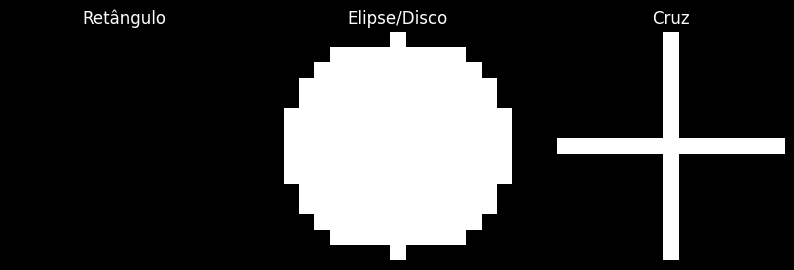

In [3]:
k = 15 # Tamanho grande para visualização
se_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (k, k))
se_ell = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
se_cross = cv2.getStructuringElement(cv2.MORPH_CROSS, (k, k))

show_side_by_side([se_rect*255, se_ell*255, se_cross*255], 
                  ["Retângulo", "Elipse/Disco", "Cruz"], size=(10,3))

## 3) Dilatação (Dilation)

**Palavra-Chave:** CRESCER / ENGORDAR.

**Regra:** Se o SE toca em **pelo menos um** pixel branco, o centro vira BRANCO.
> [!NOTE]
> Imagine espalhar fogo. Se uma faísca tocar no SE, tudo vira fogo (Branco).
> Isso fecha buracos pretos e junta objetos próximos.



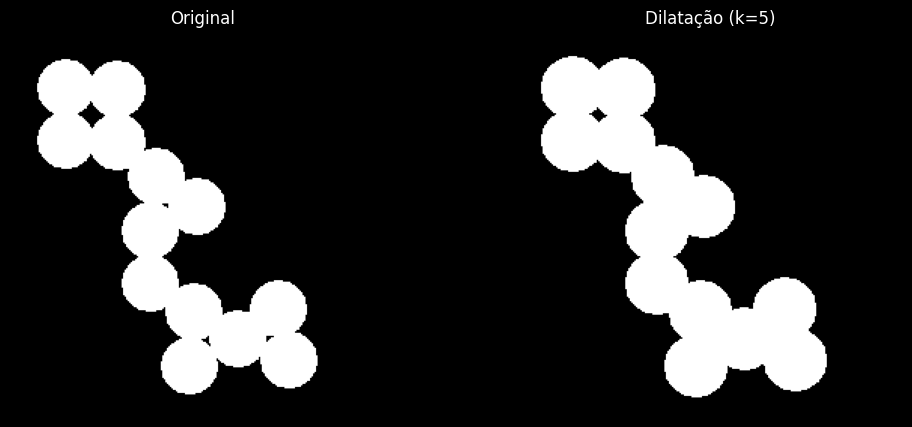

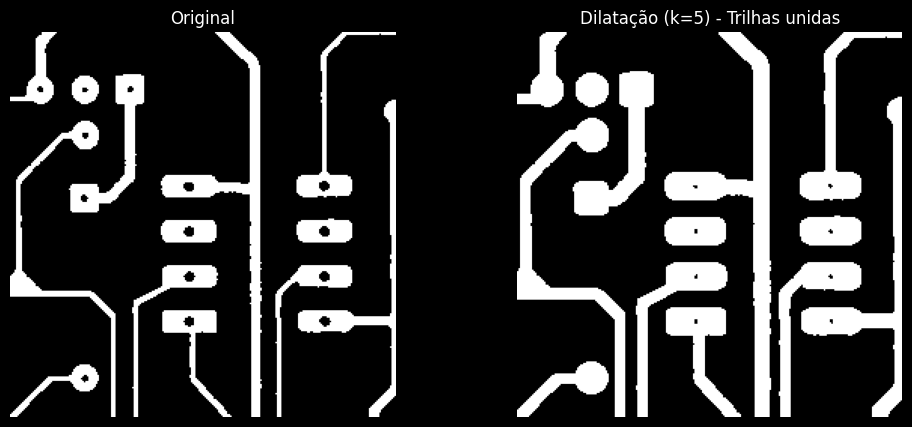

In [4]:
k = 5
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))

dil_circles = cv2.dilate(circles, se, iterations=1)
dil_circuit = cv2.dilate(circuit, se, iterations=1)

show_side_by_side([circles, dil_circles], ["Original", f"Dilatação (k={k})"], size=(12,5))
show_side_by_side([circuit, dil_circuit], ["Original", f"Dilatação (k={k}) - Trilhas unidas"], size=(12,5))

## 4) Erosão (Erosion)

**Palavra-Chave:** ENCOLHER / EMAGRECER.

**Regra:** O centro só vira BRANCO se o SE couber **inteiramente** dentro da região branca.
> [!NOTE]
> Imagine lixar as bordas. Se o SE sair um pouquinho que seja para fora (tocar no preto), o centro vira Preto.
> Isso remove ruído (pontinhos brancos isolados) e separa objetos grudados levemente.



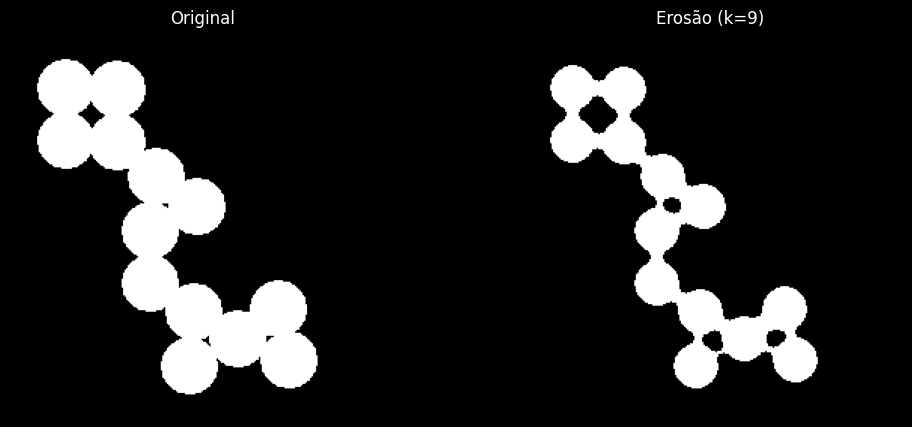

In [5]:
k = 9
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))

ero_circles = cv2.erode(circles, se, iterations=1)
# Note como os círculos menores somem ou diminuem drasticamente
show_side_by_side([circles, ero_circles], ["Original", f"Erosão (k={k})"], size=(12,5))

## 5) Abertura (Opening) = Erosão $\to$ Dilatação

**Intuição:** Limpar a sujeira ("Opening the gap").

Se fizermos **Erosão** primeiro, eliminamos os pontinhos pequenos (ruído). Mas o objeto principal também emagreceu!
Para consertar, fazemos a **Dilatação** logo em seguida. O objeto principal volta (quase) ao tamanho original, mas o ruído (que sumiu na erosão) **não volta mais** (pois desapareceu completamente).

> [!TIP]
> Use para remover **ruído branco** no fundo preto (salt noise).



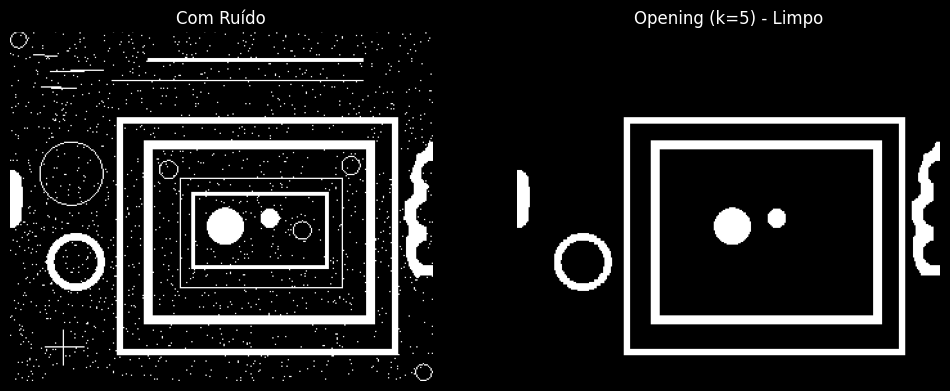

In [6]:
# Simulando ruído na imagem Squares
noisy_squares = squares.copy()
noise = np.random.randint(0, 50, squares.shape)
noisy_squares[noise < 1] = 255 # Pontos brancos aleatórios

k = 5
se = cv2.getStructuringElement(cv2.MORPH_RECT, (k, k))

# Morph Open
opening = cv2.morphologyEx(noisy_squares, cv2.MORPH_OPEN, se)

show_side_by_side([noisy_squares, opening], ["Com Ruído", f"Opening (k={k}) - Limpo"], size=(12,5))

## 6) Fechamento (Closing) = Dilatação $\to$ Erosão

**Intuição:** Tapar buracos ("Closing the hole").

Se fizermos **Dilatação** primeiro, fechamos os buraquinhos pretos dentro do objeto. O objeto engorda.
Para consertar o tamanho, fazemos a **Erosão** em seguida. O objeto volta ao tamanho, mas os buracos (que foram preenchidos) continuam fechados.

> [!TIP]
> Use para remover **ruído preto** dentro do objeto branco (pepper noise) ou para juntar letras de uma palavra que estão falhadas.



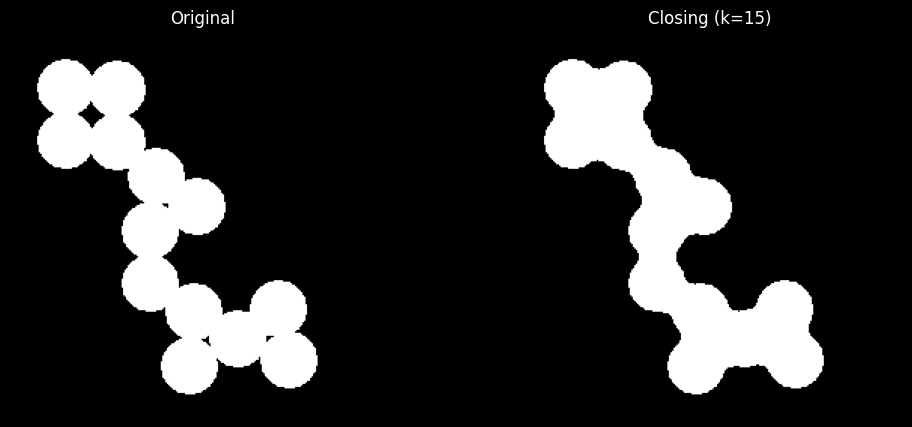

In [7]:
k = 15
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))

# Closing nos círculos conecta aqueles que estão próximos
closing = cv2.morphologyEx(circles, cv2.MORPH_CLOSE, se)

show_side_by_side([circles, closing], ["Original", f"Closing (k={k})"], size=(12,5))

## 7) Como escolher o SE? (A Regra de Ouro)

A escolha depende da **escala** do problema:
- Para **remover** um elemento (ruído, fio): SE deve ser **maior** que a largura desse elemento.
- Para **preservar** um elemento (gap): SE deve ser **menor** que o gap.

Use **Disco (Ellipse)** se a forma não importa e você quer isometria. Use **Retângulo** ou **Linha** se a geometria dos objetos for quadrada ou direcional.

## 8) Aplicações Práticas

### 8.1 Extração de Bordas
A borda é simplesmente a diferença entre a imagem original e sua versão erodida (ou dilatada - original).

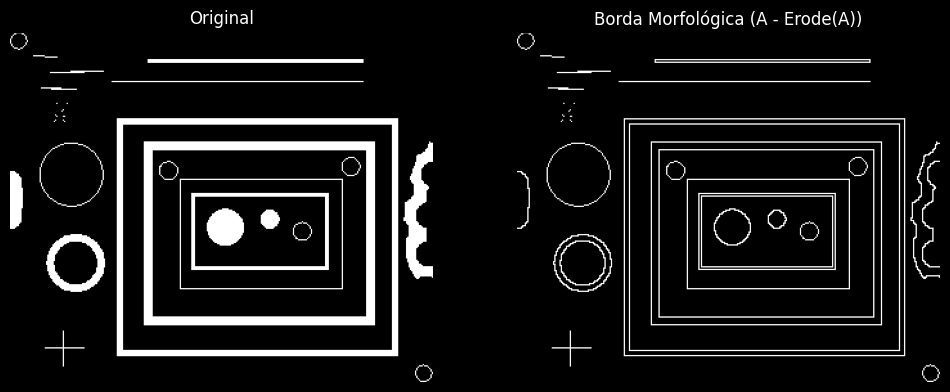

In [8]:
k = 3
se = cv2.getStructuringElement(cv2.MORPH_RECT, (k, k))

erosion = cv2.erode(squares, se, iterations=1)
edge = squares - erosion

show_side_by_side([squares, edge], ["Original", "Borda Morfológica (A - Erode(A))"], size=(12,5))

### 8.2 Limpeza para Contagem de Componentes
Um pipeline comum: `Closing` (para juntar pedaços de um mesmo objeto) -> `Opening` (para limpar ruído isolado) -> `ConnectedComponents`.

Componentes encontrados: 14


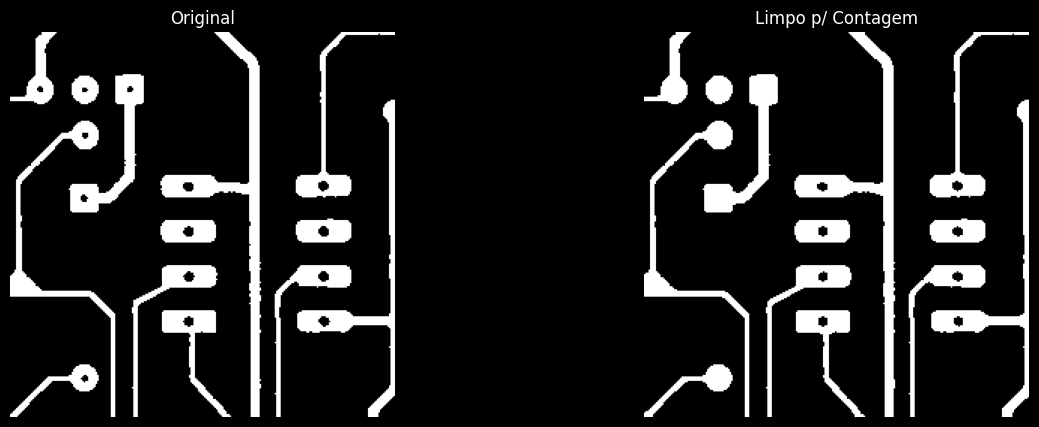

In [9]:
# Pipeline no Circuito
se_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
se_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))

step1 = cv2.morphologyEx(circuit, cv2.MORPH_CLOSE, se_close)
step2 = cv2.morphologyEx(step1, cv2.MORPH_OPEN, se_open)

num_labels, labels = cv2.connectedComponents(step2)

print(f"Componentes encontrados: {num_labels}")
show_side_by_side([circuit, step2], ["Original", "Limpo p/ Contagem"])

## 9) Bônus: Skeletonização
Reduzir objetos a linhas de 1 pixel de espessura, preservando a topologia. Útil para entender a estrutura de redes.
*Requer scikit-image.*

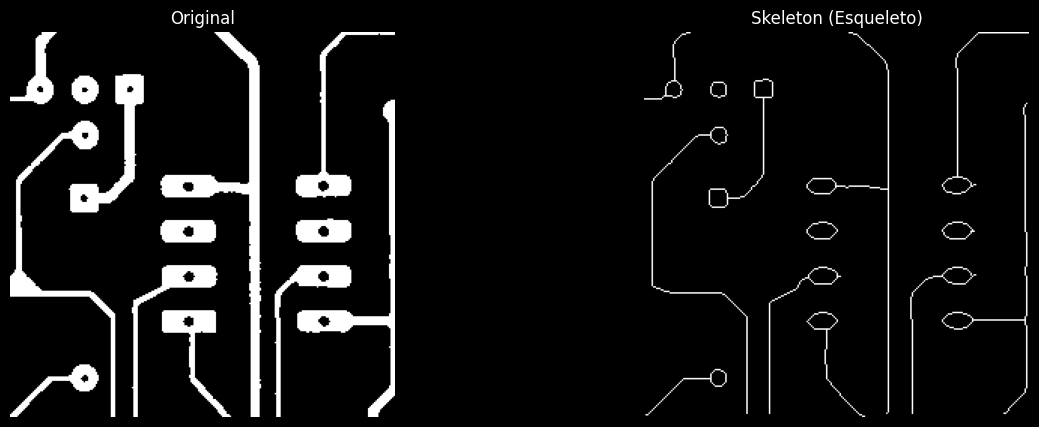

In [10]:
if HAS_SKIMAGE:
    # Skeletonize espera valores 0 e 1, ou boolean
    skel = skeletonize(circuit > 0)
    
    show_side_by_side([circuit, skel], ["Original", "Skeleton (Esqueleto)"])
else:
    print("scikit-image não instalado/encontrado para skeletonização.")

## 10) Exercícios de Fixação
1.  **Isolamento:** Em `circles.png`, use operações morfológicas para isolar **apenas** o círculo maior (removendo os pequenos).
2.  **Direcional:** Crie um SE retangular fino `(1, 15)`. Aplique `Abertura` no `circuit.png`. O que acontece? (Dica: tente isolar linhas horizontais ou verticais).
3.  **Preenchimento:** Use `cv2.floodFill` para preencher o interior do quadrado maior em `squares.png`.